In [416]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
%matplotlib inline
np.set_printoptions(suppress=True)

In [417]:
columns = ['patientFamilyID',
           'paitientFamilyMemberID',
           'providerID',
           'providerType',
           'stateCode',
           'dateOfService',
           'medicalProcedureCode',
           'dollarAmountClaim']

In [418]:
df = pd.read_csv("claims_final.csv", names=columns)
df.head()

,patientFamilyID,paitientFamilyMemberID,providerID,providerType,stateCode,dateOfService,medicalProcedureCode,dollarAmountClaim
0,518632,0,9929,122398719,NY,20060719,282,707.08
1,327546,0,2299,122398719,NY,20060526,280,381.37
2,342944,5,5367,122398782,NY,20060817,1688,889.29
3,342944,5,5367,122398782,NY,20060717,1688,889.29
4,72526,0,9029,122398719,NY,20060221,562,1681.68


## Statistics to include in slides (Not ness. for analysis)

In [419]:
print('Number of rows:', len(df))

Number of rows: 3497743


In [420]:
# Checking number of unique values of each columns
print("Number of unique values per column:")
df.T.apply(lambda x: x.nunique(), axis=1)

Number of unique values per column:


patientFamilyID           337203
paitientFamilyMemberID        23
providerID                 10025
providerType                  13
stateCode                      4
dateOfService                360
medicalProcedureCode        1520
dollarAmountClaim          31394
dtype: int64

In [421]:
print('Value count of all provider types:')
df['providerType'].value_counts()

Value count of all provider types:


122398719    3240558
122398807      67712
122398794      56374
122398782      45188
122398769      38308
122401188      20784
122399961       9569
122398744       9537
122398832       5101
122398857       3480
122398819        814
122398757        288
122398732         30
Name: providerType, dtype: int64

In [422]:
# Medical Procedure Code is not unique to provider type
# i.e. different provider types can offer the same medical procedure
# amount claim is normalized with respect to the procedure code and provider type
# if it was normalized to purely itself, then it doesn't capture that some procedures should cost different than others
# if it was normalized only to procedure, the same procedure offered by different providers could cost drastically different

df['provider_medical_concat'] = df['providerType'].astype(str).str.cat(df['medicalProcedureCode'].astype(str))

In [423]:
df['value_pm_normed'] = df.groupby('provider_medical_concat', group_keys=False)\
    .apply(lambda g: (g['dollarAmountClaim'] - g['dollarAmountClaim'].mean()) / g['dollarAmountClaim'].std())
# df['value_m_normed'] = df.groupby('medicalProcedureCode', group_keys=False)\
#     .apply(lambda g: (g['dollarAmountClaim'] - g['dollarAmountClaim'].mean()) / g['dollarAmountClaim'].std())
df.head()

,patientFamilyID,paitientFamilyMemberID,providerID,providerType,stateCode,dateOfService,medicalProcedureCode,dollarAmountClaim,provider_medical_concat,value_pm_normed
0,518632,0,9929,122398719,NY,20060719,282,707.08,122398719282,0.235735
1,327546,0,2299,122398719,NY,20060526,280,381.37,122398719280,-0.253686
2,342944,5,5367,122398782,NY,20060817,1688,889.29,1223987821688,-0.851157
3,342944,5,5367,122398782,NY,20060717,1688,889.29,1223987821688,-0.851157
4,72526,0,9029,122398719,NY,20060221,562,1681.68,122398719562,0.750598


In [424]:
# Unique Paitient ID
df['paitientID'] = df['patientFamilyID'].astype(str) + '-' + df['paitientFamilyMemberID'].astype(str)

In [425]:
df.head()

,patientFamilyID,paitientFamilyMemberID,providerID,providerType,stateCode,dateOfService,medicalProcedureCode,dollarAmountClaim,provider_medical_concat,value_pm_normed,paitientID
0,518632,0,9929,122398719,NY,20060719,282,707.08,122398719282,0.235735,518632-0
1,327546,0,2299,122398719,NY,20060526,280,381.37,122398719280,-0.253686,327546-0
2,342944,5,5367,122398782,NY,20060817,1688,889.29,1223987821688,-0.851157,342944-5
3,342944,5,5367,122398782,NY,20060717,1688,889.29,1223987821688,-0.851157,342944-5
4,72526,0,9029,122398719,NY,20060221,562,1681.68,122398719562,0.750598,72526-0


# Outlier code

In [426]:
# Base columns that are selected to help features to be engineered
potential_features = ['providerID',
                      'patientFamilyID',
                      'paitientID',
                      'value_pm_normed']

In [427]:
df_snip = df[potential_features]
df_snip['count'] = 1

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Feature Engineering

In [428]:
# Aggregating

f = {'paitientID': 'nunique',
     'value_pm_normed': 'sum',
     'patientFamilyID': 'nunique',
     'count': 'sum'}

# Renaming

rename_cols = {
    'paitientID': 'uniquePaitients',
    'patientFamilyID': 'uniqueFamilies',
}

df_agg = df_snip.groupby('providerID').agg(f)
df_agg = df_agg.rename(columns=rename_cols)

df_agg['value_pm_normed'] = df_agg['value_pm_normed'] / df_agg['count']

# Doctors with less than 5 counts are ignored
# Need to focus on having low false positives
# Even though if it means having higher false negatives
# Will manually review the counts later
#df_agg = df_agg[df_agg['count'] > 5]

df_agg.head()

,uniquePaitients,value_pm_normed,uniqueFamilies,count
providerID,,,,
1,1,1.126940,1,1
3,29,-0.355237,16,130
6,5,0.314496,4,18
7,16,0.035149,15,53
11,16,0.367385,11,56


In [429]:
# Normalizing
# Apply logarithm to convert distribution to look more like normal distribution
df_agg['countLog'] = df_agg['count'].apply(np.log)
# Normalizing
df_agg['countLogNormed'] = (df_agg['countLog'] - df_agg['countLog'].mean()) / df_agg['countLog'].std()

percent_norm_cols = ['uniquePaitients', 'uniqueFamilies']
for col in percent_norm_cols:
    temp = df_agg[col] / df_agg['count']
    df_agg[col+'Norm'] = (temp - temp.mean()) / temp.std()

In [430]:
#Dropping columns
drop_cols = ['count', 'countLog'] + percent_norm_cols
df_agg = df_agg.drop(drop_cols, axis=1)

In [431]:
X_train = df_agg.get_values()
df_agg.head()

,value_pm_normed,countLogNormed,uniquePaitientsNorm,uniqueFamiliesNorm
providerID,,,,
1,1.126940,-2.554755,4.269876,4.257524
3,-0.355237,0.097653,-0.179894,-0.484491
6,0.314496,-0.979739,0.133401,0.051643
7,0.035149,-0.391270,0.271484,0.380404
11,0.367385,-0.361267,0.178857,-0.087838


In [432]:
# Applying PCA
pca = PCA(n_components=2)
x_reduced = pca.fit_transform(X_train)

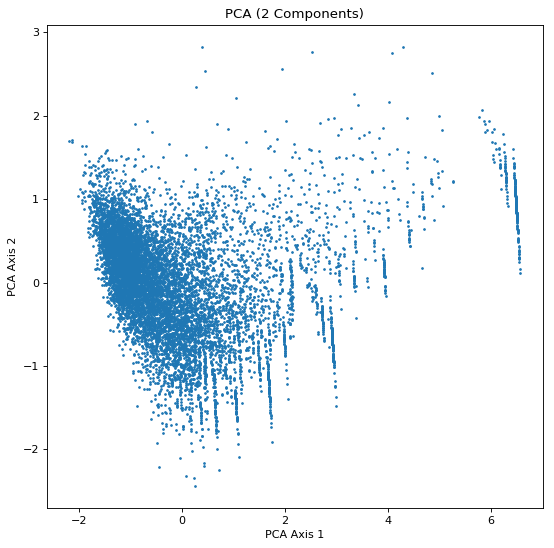

In [434]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(x_reduced[:,0], x_reduced[:,1], s = 2)
plt.xlabel('PCA Axis 1')
plt.ylabel('PCA Axis 2')
plt.title('PCA (2 Components)')

## Modelling

In [436]:
# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

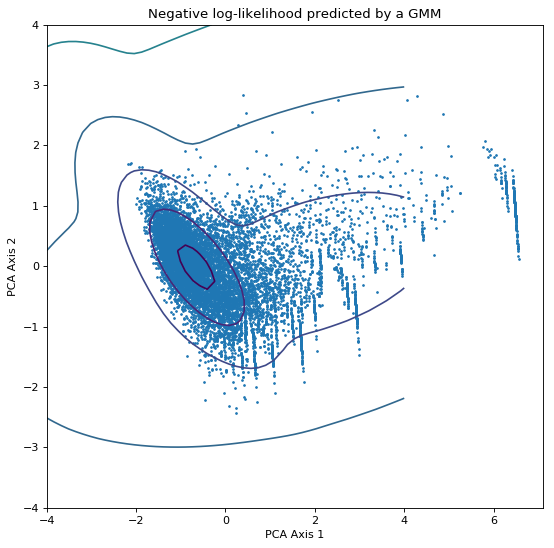

In [437]:
# PCF gaussian mixture (for visualization)
clf_v = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf_v.fit(x_reduced)
# display predicted scores by the model as a contour plot
x = np.linspace(-4., 4.)
y = np.linspace(-4., 4.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf_v.score_samples(XX)
Z = Z.reshape(X.shape)
plt.figure(figsize=(8, 8), dpi=80)
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))

plt.scatter(x_reduced[:,0], x_reduced[:,1], s = 2)
plt.xlabel('PCA Axis 1')
plt.ylabel('PCA Axis 2')
plt.title('PCA (2 Components)')

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

In [458]:
proba = np.max(clf.predict_proba(X_train), axis=1)
temp = proba.argsort()
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(proba))

In [459]:
df_agg = df_agg.reset_index()
df_agg['rank'] = pd.Series(ranks) + 1

In [460]:
dout = df_agg[['providerID', 'rank']].copy()
dout = dout.sort_values('rank')
dout.to_csv('file1.csv', header=False, index=False)

In [202]:
# Experimental, add to it later
DBS = DBSCAN(eps=0.1)
y_pred_dbs = DBS.fit_predict(x_new)
df_agg['cluster_label'] = y_pred_dbs
db_out = df_agg.groupby(by='cluster_label').mean()
db_out['cluster_count_normalized'] = pd.Series(y_pred_dbs).value_counts()
db_out

,value_pm_normed,count_log_normed,cluster_count_normalized
cluster_label,,,
-1,-0.753288,-0.732344,162
0,-0.054084,0.038814,8945
1,0.127926,-2.164169,86
2,-0.836811,-2.164169,10
3,-1.207721,-2.164169,6
4,-1.580821,-1.562003,5
